# Time forecasting for bicycle accidents 2005-2020

### Introduction

The goal of this notebook is to find forecasting models that could predict bicycle accident in France in the future. We will start by analysing seasonalities in our database. Then we will forecast accident counting by hours using *UnobservedComponents* & *Prophet* models.

### Import Libraries & packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from prophet import Prophet

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

### Import filtered dataset for bicycle accidents 2005-2020

In [2]:
df= pd.read_csv('data/bicycle_accidents_05_20_filtered.csv',sep=';', squeeze=True, parse_dates={'date':['an','mois','jour','hrmn']})
df

,date,grav,sexe,lum,agg,int,atm,catr,circ,nbv,vosp,plan,surf,infra,situ,age
0,2005-01-13 19:45:00,4,1,5,2,1,1,3,2,2,0,1,1,0,1,59
1,2005-01-19 10:45:00,3,1,1,1,1,7,3,2,2,0,3,1,0,1,21
2,2005-01-26 13:15:00,4,1,1,1,9,1,3,2,2,0,1,1,0,1,72
3,2005-01-03 13:30:00,3,2,1,2,1,1,3,2,2,0,2,1,0,1,52
4,2005-01-29 18:30:00,4,1,3,1,1,1,3,2,2,0,1,1,0,1,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74922,2020-11-30 14:25:00,3,2,1,2,1,1,7,2,4,1,1,1,0,5,61
74923,2020-11-30 17:38:00,4,2,1,2,1,1,4,2,2,0,1,1,0,1,67
74924,2020-12-01 11:11:00,4,1,1,2,3,1,4,2,2,0,1,1,0,1,67
74925,2020-12-01 13:30:00,4,2,1,2,4,2,4,2,2,0,3,2,0,8,61


### Visualizing time data

In [3]:
#select time and target columns
DF= df[['date','grav']].copy()

#to make plotting easier, we set the 'date' column as the index
DF.set_index('date', inplace=True)

#Limiting target values to binary
DF= DF.grav.replace([[1,4],[2,3]], [0,1])
#1 for killed/hospitalized category
#0 for slight_injuries/unharmed category

* We start by visualizing accidents counting according to diffrent time distributions : months, weeks, days & hours.

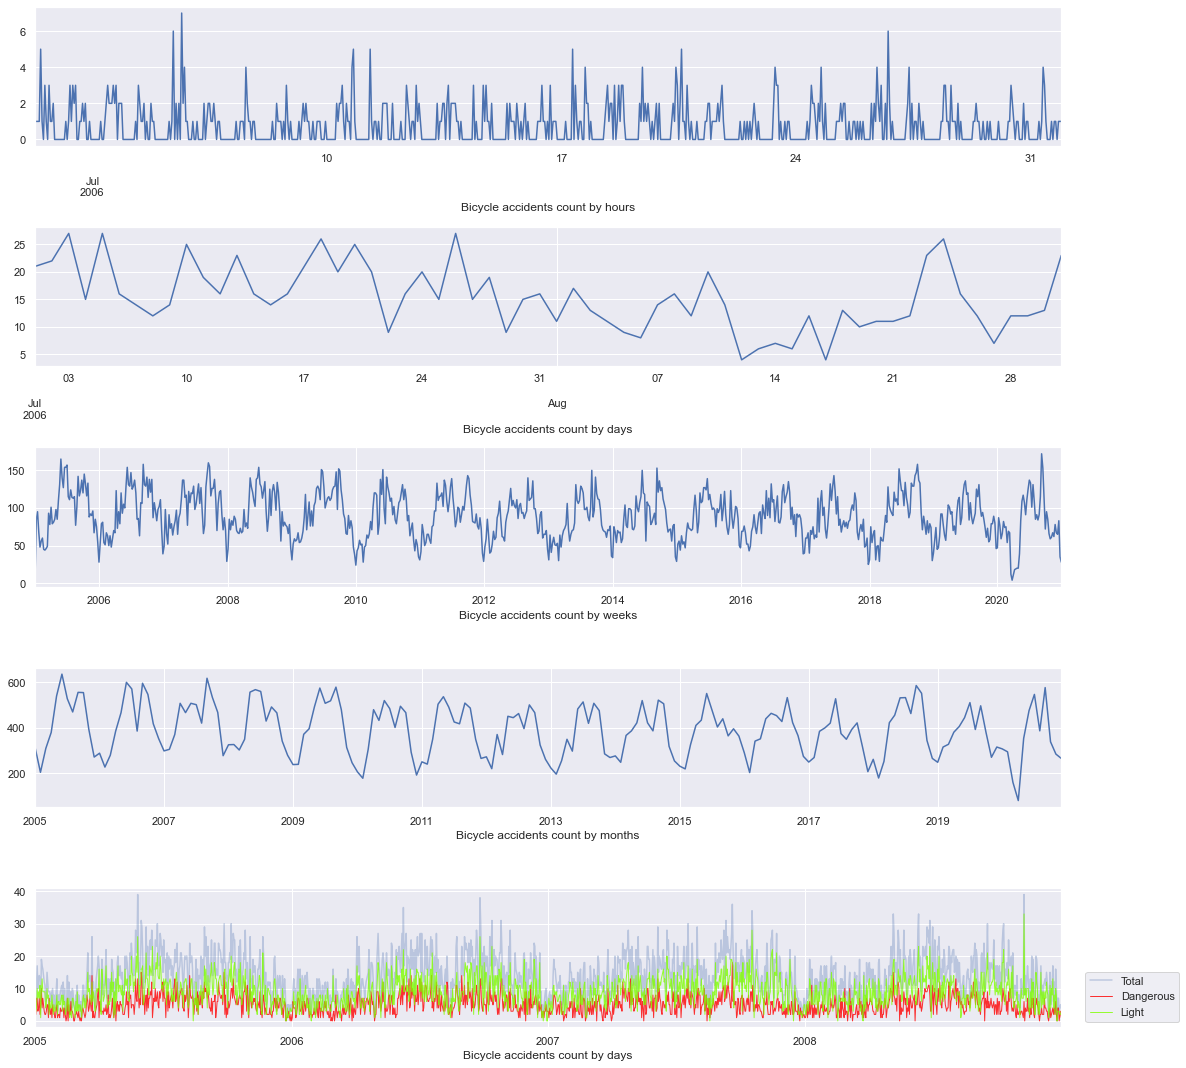

In [8]:
def count_sum(x):
    return np.ma.count(x)- np.sum(x)

plt.figure(figsize=(15,15))

plt.subplot(5,1,1)
DF['2006-07':'2006-07-31'].resample('H').count().plot(xlabel='Bicycle accidents count by hours')

plt.subplot(5,1,2)
DF['2006-07':'2006-08-31'].resample('D').count().plot(xlabel='Bicycle accidents count by days')

plt.subplot(5,1,3)
DF.resample('W').count().plot(xlabel='Bicycle accidents count by weeks')

plt.subplot(5,1,4)
DF.resample('M').count().plot(xlabel='Bicycle accidents count by months')

plt.subplot(5,1,5)
DF['2005-01':'2008-12'].resample('D').count().plot(label='Total', alpha=.3)
DF['2005-01':'2008-12'].resample('D').sum().plot(label='Dangerous', color='red', ls='-', lw=1, alpha=.8)
DF['2005-01':'2008-12'].resample('D').apply(count_sum).plot(label='Light', color='#7fff00', ls='-', lw=1, alpha=.8,
    xlabel='Bicycle accidents count by days')
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.12,0), loc="lower right");

* Next we visualize the total counting of accidents in terms of: minutes of the hour, hours of the day, days of the week, days of the month & years.

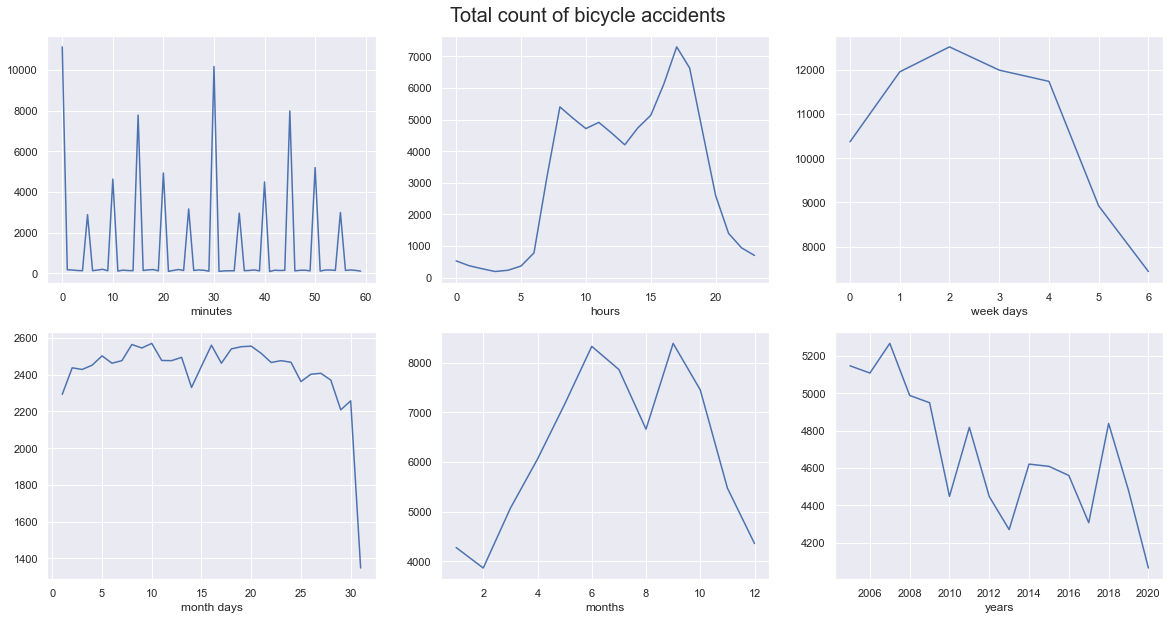

In [136]:
fig, ax= plt.subplots(2,3,figsize=(20,10))

ax[0,0].plot(DF.groupby(DF.index.minute).count())
ax[0,0].set_xlabel('minutes')

ax[0,1].plot(DF.groupby(DF.index.hour).count())
ax[0,1].set_xlabel('hours')

ax[0,2].plot(DF.groupby(DF.index.weekday).count())
ax[0,2].set_xlabel('week days')

ax[1,0].plot(DF.groupby(DF.index.day).count())
ax[1,0].set_xlabel('month days')

ax[1,1].plot(DF.groupby(DF.index.month).count())
ax[1,1].set_xlabel('months')

ax[1,2].plot(DF.groupby(DF.index.year).count())
ax[1,2].set_xlabel('years')
fig.suptitle('Total count of bicycle accidents', fontsize=20, y=0.92);
#fig.delaxes(ax[1,2])

* Judging by the two sets of graphs, we can conclude that there is a yearly, a weekly and a daily seasonalities for the bicycle accidents counting.

### Time serie decomposition

* Now that we know exactly what are the seasonalities of our time serie, we use the seasonal_decompose function n statsmodels to display the trend and each seasonality: daily, weekly & monthly.

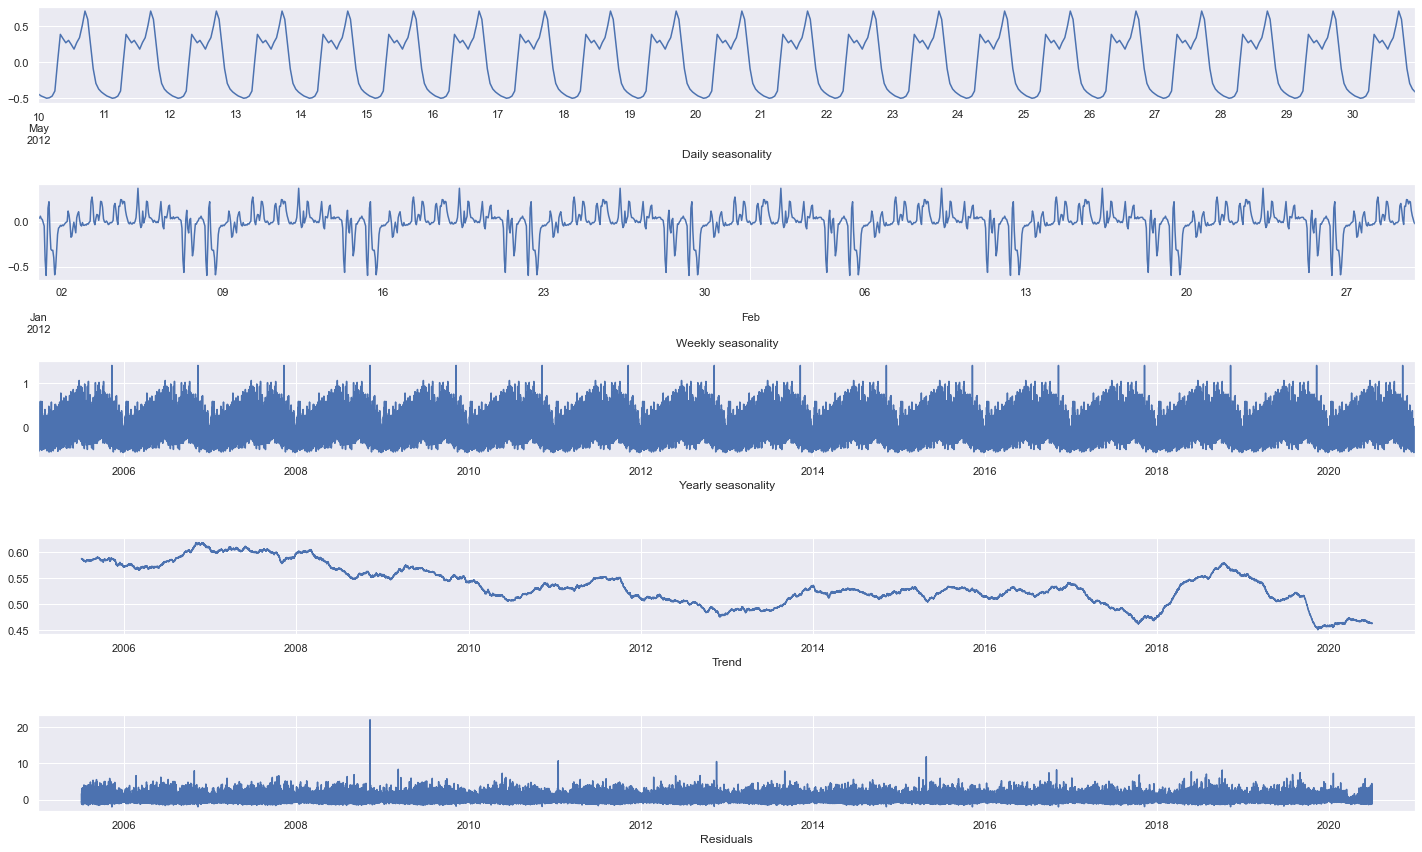

In [161]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, figsize=(20,12))

#time serie:
#rows represents accidents counting every  hour of each day between 2005 & 2020
ts= DF.resample('H').count() 

#daily sesonality: 24hours/day
decompos= sm.tsa.seasonal_decompose(ts, period=24)
decompos.seasonal['2012-05-10':'2012-05-30'].plot(ax=ax1, label='Daily seasonality', xlabel='Daily seasonality')

#weekly sesonality: 24x7hours/week
decompos= sm.tsa.seasonal_decompose(ts - decompos.seasonal, period=168)
decompos.seasonal['2012-01':'2012-02'].plot(ax=ax2, label='Weekly seasonality', xlabel='Weekly seasonality')

#yearly sesonality: 24x7x 52~53 hours/year
decompos= sm.tsa.seasonal_decompose(ts-decompos.seasonal, period=8766)
decompos.seasonal.plot(ax=ax3, label='Yearly seasonality', xlabel='Yearly seasonality')

#trend
decompos.trend.plot(ax=ax4, label='Trend', xlabel='Trend')

#residuals
decompos.resid.plot(ax=ax5, label='Residuals', xlabel='Residuals')
fig.tight_layout();

### Time forecasting using UnobservedComponents from Statsmodels

In [207]:
ts= DF.resample('H').count()

#splitting time series to train and test subsets: test_set will be the last three years
y_train = ts[:-3*8766].copy()
y_test = ts[-3*8766:].copy()

#Unobserved Components model definition
model_UC = sm.tsa.UnobservedComponents(y_train,
                                        level='dtrend',
                                        irregular=True,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 24, 'harmonics': 10},
                                                       {'period': 168, 'harmonics': 5},
                                                       {'period': 8766, 'harmonics': 5}])

#fitting model to train data
model_UC = model_UC.fit()

#printing statsmodels summary for model
print(model_UC.summary())

#model forecast
forecast_UC = model_UC.forecast(steps=len(y_test))

#Evaluation:
 #calculating mean absolute error and root mean squared error for prediction
RMSE_UC = np.sqrt(np.mean([(y_test[x] - forecast_UC[x]) ** 2 for x in range(len(forecast_UC))]))
MAE_UC = np.mean([np.abs(y_test[x] - forecast_UC[x]) for x in range(len(forecast_UC))])

print(f"Mean absolute error (MAE): {MAE_UC}, Root mean squared error (RMSE): {RMSE_UC}")


                           Unobserved Components Results                            
Dep. Variable:                         grav   No. Observations:               113946
Model:                  deterministic trend   Log Likelihood             -137498.285
                    + freq_seasonal(24(10))   AIC                         274998.571
                    + freq_seasonal(168(5))   BIC                         275008.214
                   + freq_seasonal(8766(5))   HQIC                        275001.480
Date:                      Tue, 28 Dec 2021                                         
Time:                              22:13:51                                         
Sample:                          01-01-2005                                         
                               - 12-31-2017                                         
Covariance Type:                        opg                                         
                       coef    std err          z      P>|z|     

* **Visualize forecasting and compare it to the real data:**

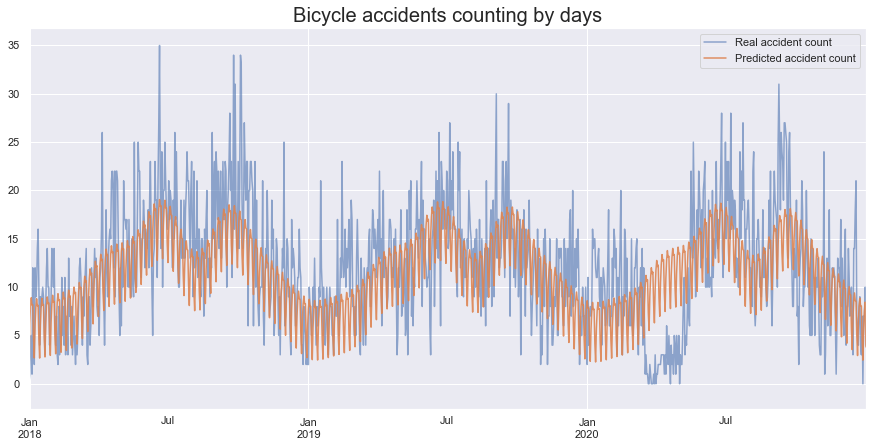

In [208]:
plt.figure(figsize=(15,7))
y_test.resample('D').sum().plot(alpha=.6, label= 'Real accident count')
forecast_UC.resample('D').sum().plot(alpha=.9,  label= 'Predicted accident count', xlabel='')
plt.title('Bicycle accidents counting by days', fontsize=20)
plt.legend();

### Time forecasting using Prophet

*Prophet* model has it's own dataset form (date columns is not the index) and column names: 
* 'ds' for date column
* 'y' for target column ('grav)

In [3]:
#define a dataset fitted to Prophet
pr_data = pd.DataFrame(df.resample('H', on='date').grav.count())
pr_data['ds']= pr_data.index
pr_data= pr_data.rename({'date':'ds', 'grav':'y'}, axis=1).reset_index(drop=True)
pr_data= pr_data[['ds','y']]
pr_data

,ds,y
0,2005-01-01 03:00:00,1
1,2005-01-01 04:00:00,0
2,2005-01-01 05:00:00,0
3,2005-01-01 06:00:00,0
4,2005-01-01 07:00:00,0
...,...,...
140239,2020-12-31 10:00:00,1
140240,2020-12-31 11:00:00,0
140241,2020-12-31 12:00:00,0
140242,2020-12-31 13:00:00,2


* **Defining our Prophet model:**

In [12]:
#split data to train and test sets: the last three years represents the test part
y_train , y_test = pr_data[pr_data.ds.dt.year<2018].reset_index(drop = True) , pr_data[pr_data.ds.dt.year>2017].reset_index(drop = True)


#Prophet model definition
model_pr= Prophet(
                    changepoint_prior_scale=0.01,
                )
                        #adding cap and floor doesn't solve the negative problem!!
#fit model to train data
model_pr.fit(y_train)

#define time set that will be predicted: in our cas it must be the same length as test data
future = model_pr.make_future_dataframe(periods=len(y_test), freq='H')

#model forecast
ypred_pr = model_pr.predict(future)

#Evaluation:
 #calculating mean absolute error and root mean squared error for prediction
RMSE_pr = np.sqrt(np.mean([(y_test.y[x] - ypred_pr.yhat[x]) ** 2 for x in range(len(y_test))]))
MAE_pr = np.mean([np.abs(y_test.y[x] - ypred_pr.yhat[x]) for x in range(len(y_test))])

print("")
print(f"Mean absolute error (MAE): {MAE_pr}, Root mean squared error (RMSE): {RMSE_pr}")
print("")

#save model
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model_pr), fout)  # Save model

#with open('serialized_model.json', 'r') as fin:
#    m = model_from_json(json.load(fin))  # Load model


Mean absolute error (MAE): 0.6483658905816122, Root mean squared error (RMSE): 0.9018125038705065



* **Visualizing forecasting components:**

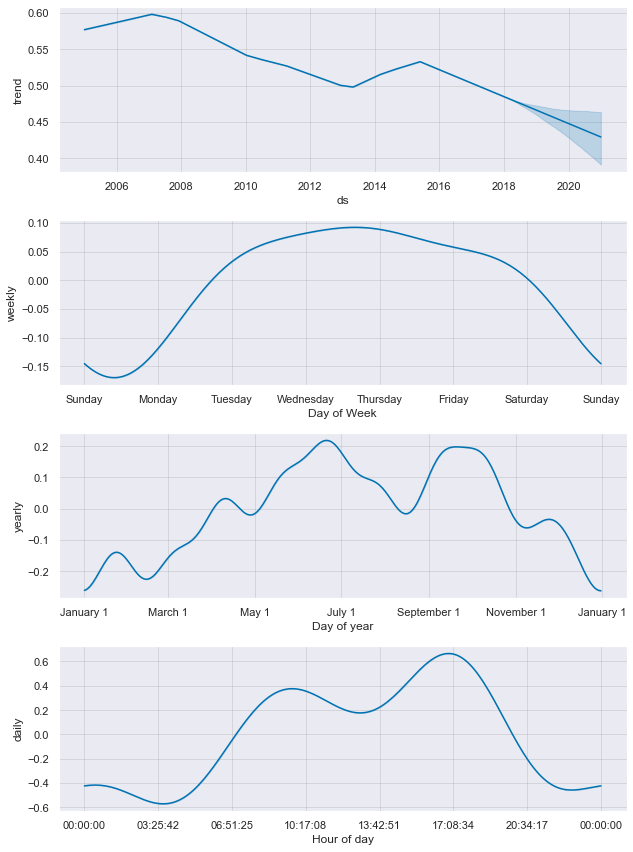

In [13]:
model_pr.plot_components(ypred_pr)
plt.show();

* **Visualize forecasting and compare it to the real data:**

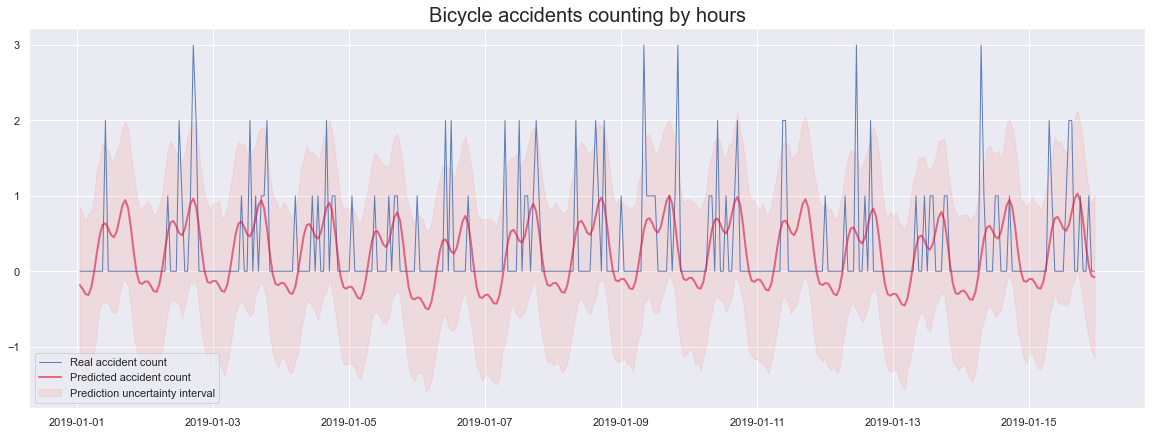

In [35]:
plt.figure(figsize=(20,7))

#ypred_pr.loc[ypred_pr.yhat<0, 'yhat']=0  #uncomment to have only positive values of the prediction

freq= 'H'

plt.plot(y_test[(y_test.ds>"2019-01-01") & (y_test.ds<"2019-01-16")].resample(freq, on='ds').sum().index,
    y_test[(y_test.ds>"2019-01-01") & (y_test.ds<"2019-01-16")].resample(freq, on='ds').sum().y, alpha=.9,
    lw='1', label='Expected accident count'
)

plt.plot(ypred_pr[(ypred_pr.ds>"2019-01-01") & (ypred_pr.ds<"2019-01-16")].resample(freq, on='ds').yhat.sum().index,
    ypred_pr[(ypred_pr.ds>"2019-01-01") & (ypred_pr.ds<"2019-01-16")].resample(freq, on='ds').yhat.sum().values, alpha=.6,
    lw='2', color='crimson', label='Predicted accident count'
)

plt.fill_between(ypred_pr[(ypred_pr.ds>"2019-01-01") & (ypred_pr.ds<"2019-01-16")].resample(freq, on='ds').yhat.sum().index,
    ypred_pr[(ypred_pr.ds>"2019-01-01") & (ypred_pr.ds<"2019-01-16")].resample(freq, on='ds').yhat_lower.sum().values,
    ypred_pr[(ypred_pr.ds>"2019-01-01") & (ypred_pr.ds<"2019-01-16")].resample(freq, on='ds').yhat_upper.sum().values,
    color='salmon', alpha=.15, label='Prediction uncertainty interval' 
)

plt.title('Bicycle accidents counting by hours', fontsize=20)
plt.legend();

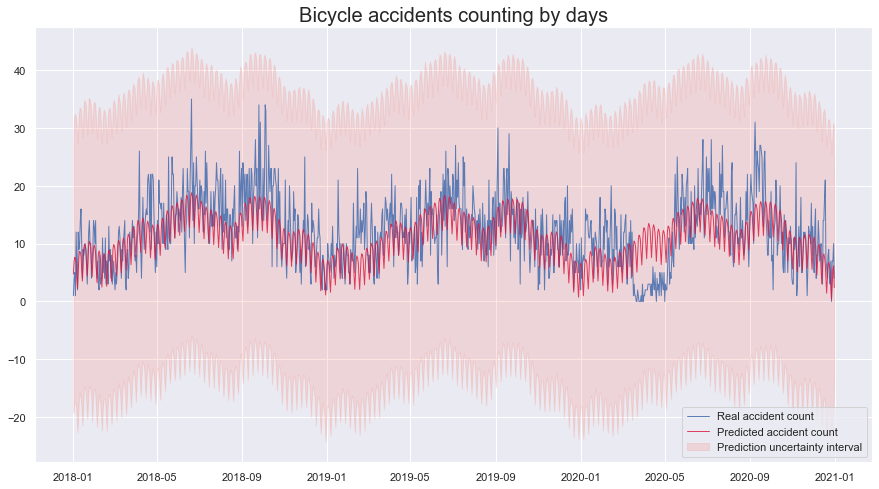

In [39]:
plt.figure(figsize=(15,8))

freq= 'D'
plt.plot(y_test[ y_test.ds>"2018"].resample(freq, on='ds').sum().index,
    y_test[ y_test.ds>"2018"].resample(freq, on='ds').sum().y, alpha=.9, label='Expected accident count',
    lw='1'
)

plt.plot(ypred_pr[ ypred_pr.ds>"2018"].resample(freq, on='ds').yhat.sum().index,
    ypred_pr[ypred_pr.ds>"2018"].resample(freq, on='ds').yhat.sum().values, alpha=.8, label='Predicted accident count',
    lw='1', color='crimson'
)
plt.fill_between(ypred_pr[ ypred_pr.ds>"2018"].resample(freq, on='ds').yhat.sum().index,
    ypred_pr[ypred_pr.ds>"2018"].resample(freq, on='ds').yhat_lower.sum().values,
    ypred_pr[ypred_pr.ds>"2018"].resample(freq, on='ds').yhat_upper.sum().values,
    color='salmon', alpha=.2, label='Prediction uncertainty interval' 
)

plt.title('Bicycle accidents counting by days', fontsize=20)
plt.legend(loc='lower right');